# Sydney House Prices
***

House prices in Sydney have been the subject of great attention in Australia and globally. Specifically, for their extraordinarily high prices. Being a resident of Sydney, I was interested in seeing the relative prices across the different suburbs I live around. I wanted a way I could visualise these geospatial relationships myself. 

> A choropleth map (from Greek χῶρος choros 'area/region' and πλῆθος plethos 'multitude') is a type of thematic map in which a set of pre-defined areas is colored or patterned in proportion to a statistical variable that represents an aggregate summary of a geographic characteristic within each area, such as population density or per-capita income.

In [2]:
# import necessary libraries
%reload_ext autoreload

# general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import os
import requests
import json
import matplotlib.ticker as ticker
import geojson

import yaml
from box import Box

import plotly.offline as pyo

from urllib.request import urlopen

# utility module
from sydneyhouseprices.data import remoteGeoJSONToGDF

# display options
pd.options.display.float_format = '{:,.2f}'.format

sns.set_style("ticks")
sns.set_palette('pastel')


## Gathering Data
The data I used can be found [here](https://www.kaggle.com/mihirhalai/sydney-house-prices#__sid=js0). I use a YAML file for configurations parameters. I use this mainly for more readable code and easier parameter tweaking to help me in the future. They look similar to a dictionary format with keys and value pairs. 

YAML (a recursive acronym for "YAML Ain't Markup Language") is a human-readable data-serialization language. It is commonly used for configuration files and in applications where data is being stored or transmitted.  

In [3]:
# import YAML config files and setup to use
with open("config.yml", "r") as ymlfile:
  cfg = Box(yaml.safe_load(ymlfile))

# import data
house_prices_syd = pd.read_csv(os.path.join(cfg.files.data,"SydneyHousePrices.csv"),index_col=0,parse_dates=True,)

## Inspect and Cleaning the Data

As with all data science tasks, we want to inspect our data and gather some elementary information about the features, labels and variable types.

In [4]:
house_prices_syd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199504 entries, 2019-06-19 to 2011-04-16
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          199504 non-null  int64  
 1   suburb      199504 non-null  object 
 2   postalCode  199504 non-null  int64  
 3   sellPrice   199504 non-null  int64  
 4   bed         199350 non-null  float64
 5   bath        199504 non-null  int64  
 6   car         181353 non-null  float64
 7   propType    199504 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 13.7+ MB


<br>

There are 199,504 entries, spanning from 2011-04-16 to 2019-06-19. Quite a large number of data points here. There are 8 columns (zero-indexed) of various types.

The `sellPrice` and `propType` columns should be appropriately changed to floats as selling prices are continious variables and property types to categories as they are... categorical. This will make pandas methods more informative.

In [5]:
# change types of values in columns
house_prices_syd['sellPrice'] = house_prices_syd['sellPrice'].astype('float')
house_prices_syd['propType'] = house_prices_syd['propType'].astype('category')

# check changes
house_prices_syd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199504 entries, 2019-06-19 to 2011-04-16
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Id          199504 non-null  int64   
 1   suburb      199504 non-null  object  
 2   postalCode  199504 non-null  int64   
 3   sellPrice   199504 non-null  float64 
 4   bed         199350 non-null  float64 
 5   bath        199504 non-null  int64   
 6   car         181353 non-null  float64 
 7   propType    199504 non-null  category
dtypes: category(1), float64(3), int64(3), object(1)
memory usage: 12.4+ MB


Great! Our values now are of a more appropriate type. Now to continue inspecting the dataframe.

In [6]:
house_prices_syd.head()

,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
Date,,,,,,,,
2019-06-19,1,Avalon Beach,2107,"1,210,000.00",4.00,2,2.00,house
2019-06-13,2,Avalon Beach,2107,"2,250,000.00",4.00,3,4.00,house
2019-06-07,3,Whale Beach,2107,"2,920,000.00",3.00,3,2.00,house
2019-05-28,4,Avalon Beach,2107,"1,530,000.00",3.00,1,2.00,house
2019-05-22,5,Whale Beach,2107,"8,000,000.00",5.00,4,4.00,house


There are a few columns that are reduntant for our analyses. We can remove the `id` and `postalCode` columns.

In [7]:
# drop uneccesary columns

clean_house_prices_syd = house_prices_syd.drop(axis=1,labels=["Id","postalCode"])
clean_house_prices_syd.head()

,suburb,sellPrice,bed,bath,car,propType
Date,,,,,,
2019-06-19,Avalon Beach,"1,210,000.00",4.00,2,2.00,house
2019-06-13,Avalon Beach,"2,250,000.00",4.00,3,4.00,house
2019-06-07,Whale Beach,"2,920,000.00",3.00,3,2.00,house
2019-05-28,Avalon Beach,"1,530,000.00",3.00,1,2.00,house
2019-05-22,Whale Beach,"8,000,000.00",5.00,4,4.00,house


To quickly get an overview of our data and it's statistical properties we can use the `describe` method on the dataframe. We tranpose the dataframe to make viewing it easier.

In [8]:
# summary stats
clean_house_prices_syd.describe().T

,count,mean,std,min,25%,50%,75%,max
sellPrice,"199,504.00","1,269,776.30","6,948,239.27",1.00,"720,000.00","985,000.00","1,475,000.00","2,147,483,647.00"
bed,"199,350.00",3.52,1.07,1.00,3.00,3.00,4.00,99.00
bath,"199,504.00",1.89,0.93,1.00,1.00,2.00,2.00,99.00
car,"181,353.00",1.94,1.06,1.00,1.00,2.00,2.00,41.00


Immediately some interesting properties stand out.

- There is a property that supposedely sold for $2,147,483,647$ (the `max` entry). This must be an erroneous value. For context the Rupert Mudorch family is worth $20.7b$ at time of writing. This seems like a mistake, removing this value would be the sensible thing to do so the calculated statistics aren't skewed incorrectly. 

- Another interesting point is that if you own a house that is valued at 1.475m you are in the 75th percentile of home owners. This means that your property is more expensive than 75% of the properties in Sydney according to this dataset.

- Additionally houses that are sold for $1.00 are likely to be invalid values so we should deal with these values accordingly. Doing some research into a sensible minimum selling price can filter out illogical prices.

**There is some work to do dealing with the outliers in this dataset.**

We can begin by removing the max value in our dataset and then check how this has impacted our summary statistics.

In [9]:
clean_house_prices_syd.max()

suburb               Zetland
sellPrice   2,147,483,647.00
bed                    99.00
bath                      99
car                    41.00
dtype: object

In [10]:
clean_house_prices_syd['sellPrice'].idxmax()

Timestamp('2010-05-17 00:00:00')

Supposedly this property was sold in 2010, in Zetland, with `99` bedrooms and `41` car spaces. Even if this was a big property development (block of units, skyscraper) this price does not make sense. For further context the GDP of Estonia is around the same as this outlier.

Lets drop this value.

In [11]:
clean_house_prices_syd.drop(index=clean_house_prices_syd['sellPrice'].idxmax(axis=1),inplace=True)

Lets double check our change.

In [12]:
clean_house_prices_syd.describe().T

,count,mean,std,min,25%,50%,75%,max
sellPrice,"199,464.00","1,259,039.61","5,019,368.59",1.00,"720,000.00","985,000.00","1,475,000.00","2,147,483,647.00"
bed,"199,310.00",3.52,1.07,1.00,3.00,3.00,4.00,99.00
bath,"199,464.00",1.89,0.93,1.00,1.00,2.00,2.00,99.00
car,"181,320.00",1.94,1.06,1.00,1.00,2.00,2.00,41.00


Woah! Our standard deviation has dropped significantly, as expected, by around $5.5m$. This is important as any inferences or analyses would have been quite off the mark if we included our Estonia priced property.

Let us continue by addressing the lower range of our dataset. I believe a sensible amount for the lower range would be property prices greater than $\$10,000$.

In [13]:
# Remove all properties less than $10,000

drop = clean_house_prices_syd[clean_house_prices_syd['sellPrice'] < 10000]
clean_house_prices_syd.drop(index=drop.index, inplace=True)

In [14]:
# check that the minimum house is sold for $10,000

clean_house_prices_syd.min()

suburb       Abbotsbury
sellPrice     10,000.00
bed                1.00
bath                  1
car                1.00
dtype: object

After some preliminary and elementary data preprocessing we can now explore our data and find answers to some interesting questions. Maybe we can begin with:

## Exploratory Data Analysis


> **Which 10 suburbs sold the most properties?**

In [15]:
# number of houses sold over the time period per suburb

sold_per_suburb = clean_house_prices_syd["suburb"].value_counts()
sold_per_suburb.head(10)

Castle Hill           1233
Ermington             1230
Marrickville          1229
Carlingford           1225
Cherrybrook           1222
Auburn                1221
West Pennant Hills    1221
Strathfield           1220
St Ives               1214
Macquarie Fields      1211
Name: suburb, dtype: int64

<br>

Interesting, Castle Hill located 30 kilometres north-west of the Sydney central business districtand 9.5 kilometres north of Parramatta, tops the list. It is within the Hills District region, split between the local government areas of The Hills Shire and Hornsby Shire. Castle Hill residents have a **personal income that is 18.9% greater than the median national income**, according to the 2016 Census. This may indicate that Castle Hill may be of interest to property analysts.

Another interesting metric, which will later be used for the choropleth map is the median house price (a statistic that isn't skewed by outliers) for each suburb.

In [16]:
# calculate median stats for each suburb to use on the choropleth map

median_statistics = clean_house_prices_syd.groupby("suburb").median()
median_statistics.head()

,sellPrice,bed,bath,car
suburb,,,,
Abbotsbury,"975,000.00",4.00,3.00,2.00
Abbotsford,"1,285,000.00",3.00,2.00,2.00
Agnes Banks,"715,000.00",4.00,2.00,2.00
Airds,"505,000.00",4.00,1.00,2.00
Alexandria,"1,037,000.00",3.00,1.00,1.00


In [17]:
median_statistics[median_statistics.index == "Zetland"]

,sellPrice,bed,bath,car
suburb,,,,
Zetland,"1,130,000.00",3.00,2.00,1.00


Out of interest, the large outlier which was the 20.7b property, was located in Zetland, where the median house price is 1.130m. More evidence that this value was bonkers.



**What are the suburbs with the highest median prices in Sydney?**

In [18]:
median_statistics.sort_values(by='sellPrice', ascending=False).head(10)

,sellPrice,bed,bath,car
suburb,,,,
Point Piper,"7,575,000.00",4.50,4.00,2.00
Collaroy Beach,"4,900,000.00",5.00,3.00,2.00
Darling Point,"4,800,000.00",4.00,3.00,2.00
Woolwich,"4,520,000.00",4.00,3.00,2.00
Bellevue Hill,"3,750,000.00",4.00,3.00,2.00
Kurraba Point,"3,650,000.00",4.00,2.00,2.00
Vaucluse,"3,580,000.00",4.00,3.00,2.00
Willoughby East,"3,410,000.00",3.00,2.00,2.00
Cremorne Point,"3,317,500.00",4.00,2.50,2.00


Unsuprisingly *Point Piper* is the highest median selling price. Next on the list is *Collaroy Beach*, another coastal suburb but in the Northern Beaches. It seems that the old adage that coastal properties house the elite may be correct according to these high selling prices.

The next step to get a better feel for our data is to visualise some relationships.

# Visualisations

Our data has a temporal dimension. With each sale there is a timestamp that is attached to that sale. An interesting insight may be which where the most popular months of the sale of properties around sydney.

In [19]:
# Count Number of sales made in each month and turn into a dataframe
sold_per_month = pd.DataFrame(clean_house_prices_syd.index.month_name().value_counts())

# Rename Date column to Sold per Month
sold_per_month.rename(columns={'Date':'Sold per Month'},inplace=True)
sold_per_month.head()

,Sold per Month
March,20794
November,19987
May,19400
October,17899
September,17689


<Figure size 1440x720 with 0 Axes>

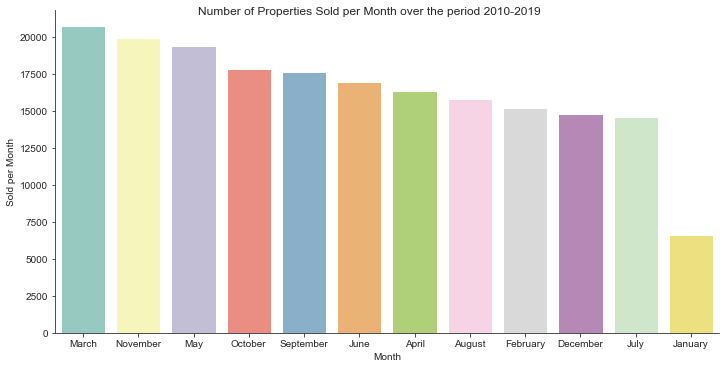

In [20]:
# Configure plot size
plt.figure(figsize=(20,10))

# Plot the data
sold_per_month_fig = sns.catplot(x=sold_per_month.index,y='Sold per Month',kind='bar',data=sold_per_month,aspect=2,palette="Set3")

# Add title, x-axis label
sold_per_month_fig.fig.suptitle('Number of Properties Sold per Month over the period 2010-2019')
sold_per_month_fig.set_xlabels('Month')

plt.show()

As we see January is the month in which the least number of properties were sold. March was the highest month sold.

## Distributions

What are the distribution shapes of our features and labels?

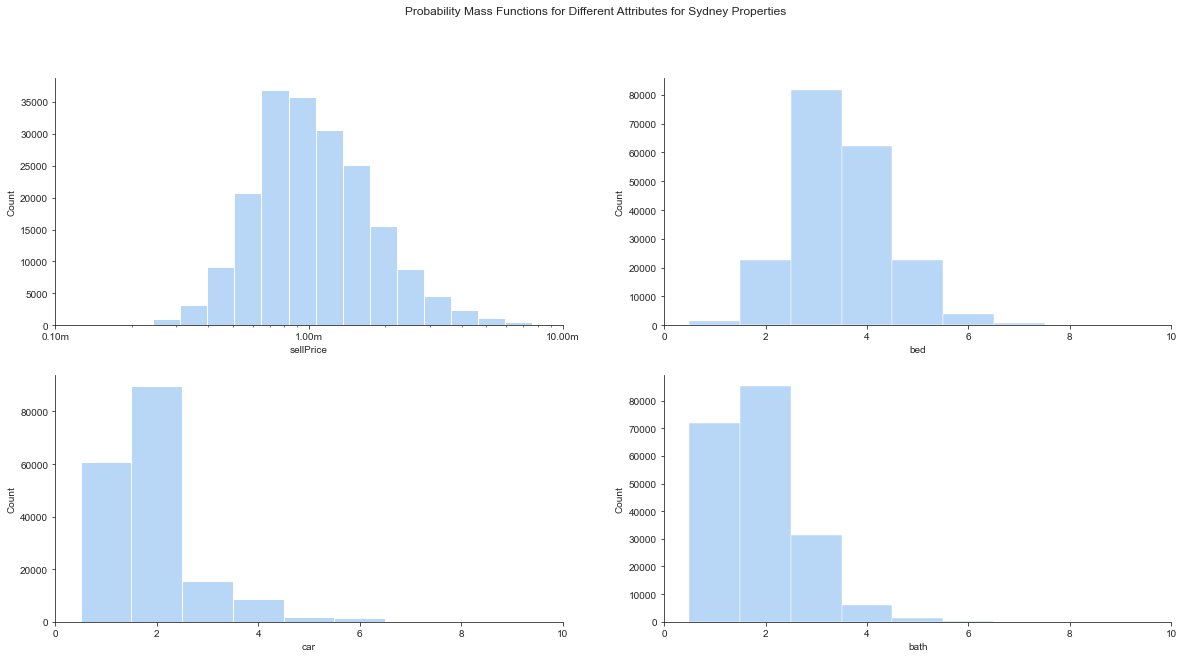

In [21]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.despine()
sns.set_style("ticks")

# selling histogram
sell = sns.histplot(data=clean_house_prices_syd, x='sellPrice', ax=ax[0,0], log_scale=True,  bins=50)
sell.axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'm'))
sell.set_xlim(100000,10000000)

# bed histogram
bed = sns.histplot(data=clean_house_prices_syd, x='bed', discrete=True, ax=ax[0,1])

bed.set_xlim(0,10)

# car histogram
car = sns.histplot(data=clean_house_prices_syd, x ='car', discrete=True, ax=ax[1,0])

car.set_xlim(0,10)

# bath histogram 
bath = sns.histplot(data=clean_house_prices_syd, x ='bath', discrete=True, ax=ax[1,1])

bath.set_xlim(0,10)

# title
fig.suptitle('Probability Mass Functions for Different Attributes for Sydney Properties');

- `sellPrice`:
- `bed`:
- `car`:
- `bed`:

In [38]:
clean_house_prices_syd.to_csv('prices_data.csv')

### Cumalative Distribution Functions

<ipython-input-39-b6da355fd0cf>:6: UserWarning:

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



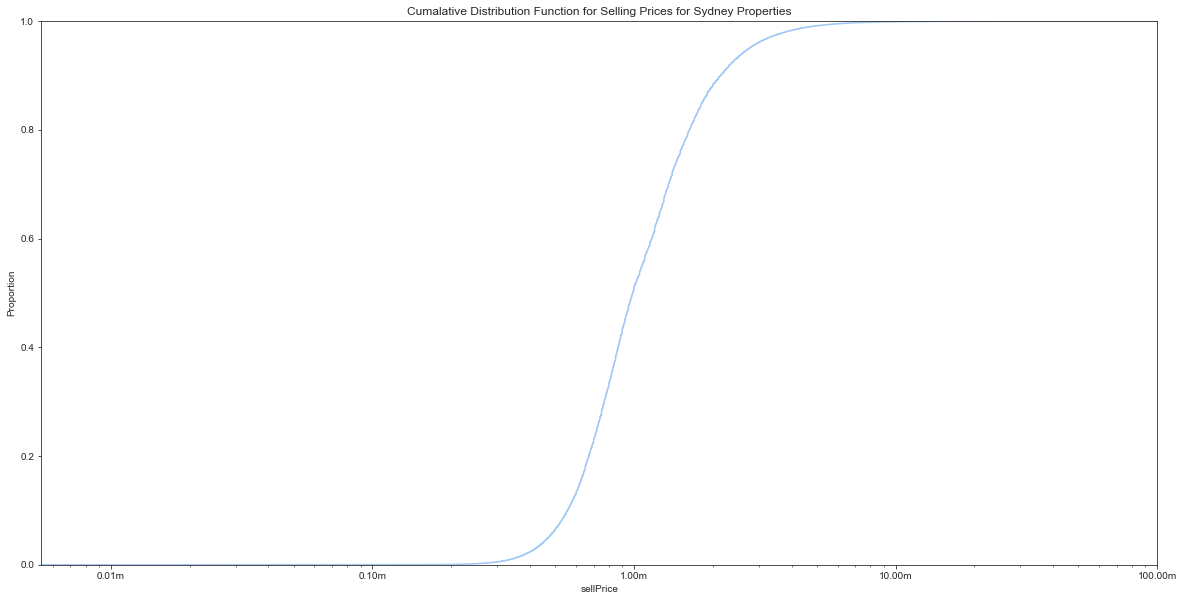

In [39]:
plt.figure(figsize=(20,10))

ecdf = sns.ecdfplot(clean_house_prices_syd, x='sellPrice')

ecdf.set_xscale('log')

# observe that we can't set a non-positive limit for a log-scaled value.
plt.xlim(0.01,100000000)

ecdf.axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'm'))

ecdf.set_title('Cumalative Distribution Function for Selling Prices for Sydney Properties');

In [25]:
clean_house_prices_syd.sellPrice.median()

990000.0

In [26]:
bin_size = int(np.sqrt(clean_house_prices_syd['sellPrice'].shape))


### Correlation Heatmap

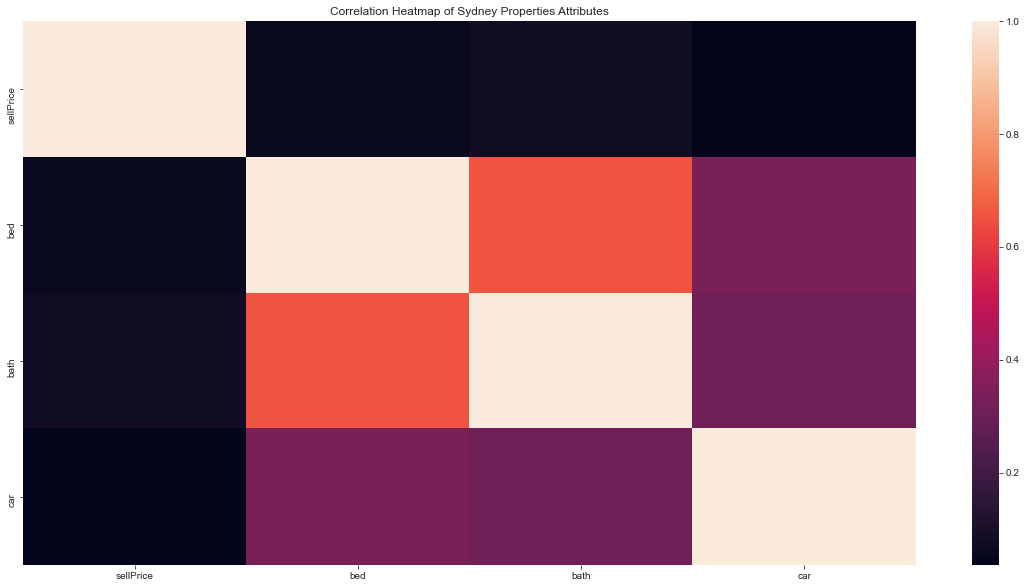

In [27]:
plt.figure(figsize=(20,10))

corr = clean_house_prices_syd.corr()

sns.heatmap(corr)

plt.title("Correlation Heatmap of Sydney Properties Attributes");

### Scatter Plots

(-5.0, 25.0)

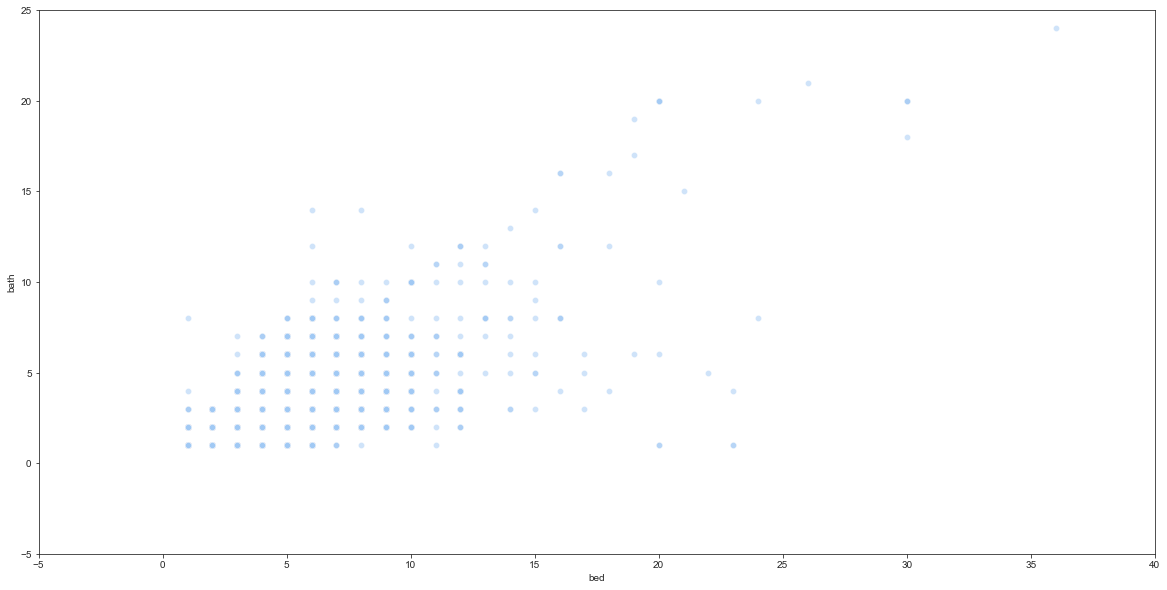

In [28]:
plt.figure(figsize=(20,10))

sns.scatterplot(data=clean_house_prices_syd, x='bed', y='bath',alpha=0.5)
plt.xlim(-5,40)
plt.ylim(-5,25)


# Boxplot

A boxplot is a useful way to compare continous values across different categorical types. Here we can analyse differences between different property types in Sydney.

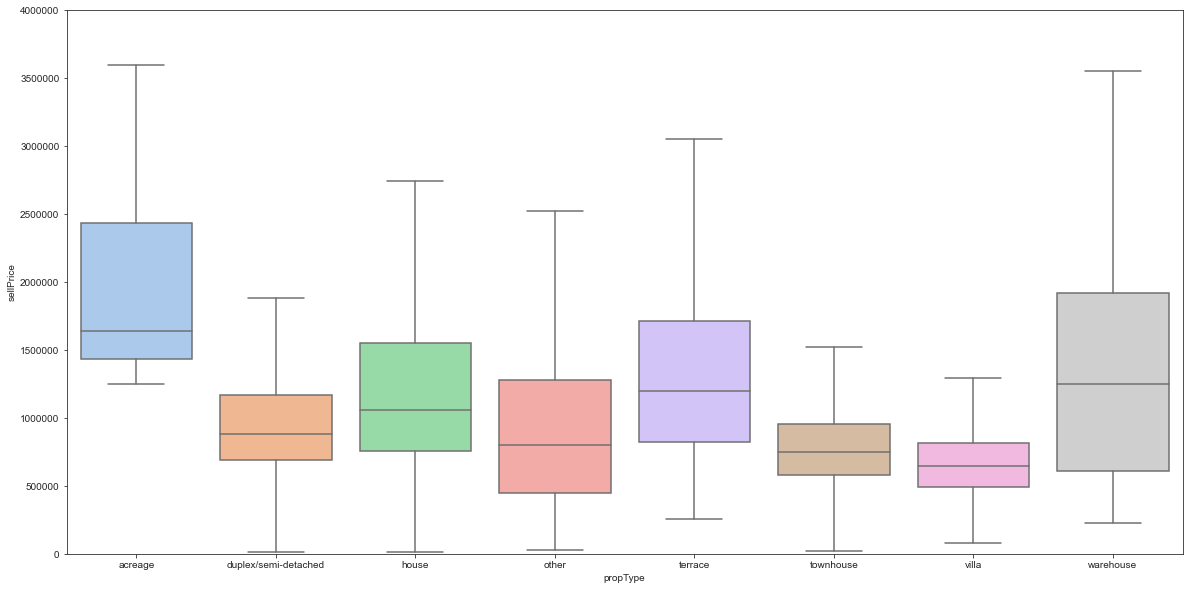

In [29]:
plt.figure(figsize=(20,10))

p = sns.boxplot(x=clean_house_prices_syd['propType'],y=clean_house_prices_syd['sellPrice'],showfliers = False)
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0,4000000);

# Creating the Choropleth Map

To create a choropleth map using plotly we need a couple of things:

- A json file with the relevant geometric properties of the shapes of different polygons that describe the surrounding suburbs.
- We need to our values to match on a common field in the exact order of the json file, thus we need a dataframe with matching values and geometric properties.

We imported a useful helper function that will grab the relevant json from the internet and saves it as a geopandas dataframe. This will be useful when merging the data.

In [30]:
# import data geospatial data
sydney = remoteGeoJSONToGDF(cfg.files.sydneyurl)
sydney.head()

,geometry,lc_ply_pid,dt_create,dt_retire,loc_pid,nsw_locali,nsw_loca_1,nsw_loca_2,nsw_loca_3,nsw_loca_4,nsw_loca_5,nsw_loca_6,nsw_loca_7
0,"MULTIPOLYGON (((151.10074 -33.84457, 151.10082...",24903,2015-09-03Z,None,NSW1012,2015-11-10Z,None,CONCORD,None,None,G,None,1
1,"MULTIPOLYGON (((151.19808 -33.82566, 151.19816...",25101,2015-09-03Z,None,NSW4391,2015-11-10Z,None,WOLLSTONECRAFT,None,None,G,None,1
2,"MULTIPOLYGON (((151.10398 -33.81987, 151.10406...",19669,2012-11-21Z,None,NSW3304,2013-01-23Z,None,PUTNEY,None,None,G,None,1
3,"MULTIPOLYGON (((151.08348 -33.30938, 151.09335...",24793,2015-09-03Z,None,NSW3819,2015-11-10Z,None,TEN MILE HOLLOW,None,None,G,None,1
4,"MULTIPOLYGON (((151.16649 -33.75486, 151.16677...",20526,2013-03-07Z,None,NSW2153,2013-04-30Z,None,KILLARA,None,None,G,None,1


In [36]:
sydney.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  698 non-null    geometry
 1   suburb    698 non-null    object  
dtypes: geometry(1), object(1)
memory usage: 11.0+ KB


We can see that the `nsw_loca_2` is the most obvious key to match on. The first column are our geometry parameters that will plotly will use to plot our map. However one issue still exists. We need to make sure the strings in the `nsw_loca_2`are formatted in the same way as the median statistics dataframe. From a quick inspection that dataframe had suburbs in a proper noun format. We will change the geopandas df to reflect this.

In [31]:
# cleaning the geopandas dataframe
sydney = sydney[["geometry","nsw_loca_2"]]
sydney.rename(columns={"nsw_loca_2":"suburb"},inplace=True)

# change to proper nouns to match our geojson file
sydney.suburb = sydney.suburb.str.title()
sydney.head()

,geometry,suburb
0,"MULTIPOLYGON (((151.10074 -33.84457, 151.10082...",Concord
1,"MULTIPOLYGON (((151.19808 -33.82566, 151.19816...",Wollstonecraft
2,"MULTIPOLYGON (((151.10398 -33.81987, 151.10406...",Putney
3,"MULTIPOLYGON (((151.08348 -33.30938, 151.09335...",Ten Mile Hollow
4,"MULTIPOLYGON (((151.16649 -33.75486, 151.16677...",Killara


Awesome! Now we can merge our two dataframes. We want to do an inner merge, which will match all rows that are common to both dataframes.

In [32]:
# merge median values for each suburb with the geopandas dataframe, using a left join so we retain polygons for null.

geo_house_prices = pd.merge(sydney,median_statistics,left_on="suburb",right_on=median_statistics.index,how="inner")
geo_house_prices.set_index("suburb",inplace=True)
geo_house_prices.head()

,geometry,sellPrice,bed,bath,car
suburb,,,,,
Concord,"MULTIPOLYGON (((151.10074 -33.84457, 151.10082...","1,417,500.00",3.00,2.00,2.00
Wollstonecraft,"MULTIPOLYGON (((151.19808 -33.82566, 151.19816...","1,370,000.00",3.00,2.00,2.00
Putney,"MULTIPOLYGON (((151.10398 -33.81987, 151.10406...","1,743,500.00",3.00,2.00,2.00
Killara,"MULTIPOLYGON (((151.16649 -33.75486, 151.16677...","1,900,500.00",4.00,3.00,2.00
Hammondville,"MULTIPOLYGON (((150.96371 -33.94743, 150.96424...","740,000.00",3.00,1.00,1.00


In [33]:
geo_house_prices.to_csv('map_data.csv')

In [34]:
token = open('.mapbox_token').read()

data = px.choropleth_mapbox(geo_house_prices, 
                            geojson=geo_house_prices.geometry,
                            locations=geo_house_prices.index, color='sellPrice',
                            color_continuous_scale="viridis",
                            center = {"lat": cfg.map.lat, "lon": cfg.map.lon},
                            range_color=(0, 2000000),
                            labels= {"sellPrice":"Selling Price","suburb":"Suburb"},
                            mapbox_style='open-street-map',
                            opacity=0.5
                          )


fig = go.Figure(data = data)


fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)

fig.show()

KeyboardInterrupt: 